In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

from quantipy.assets import Currency, Equity
from quantipy.trading import Broker, TripleMovingAverage
from quantipy.backtest import Backtester

%matplotlib inline
warnings.filterwarnings('ignore')

# backtest period
BACKTEST_START = '2016-01-01'
LIVE_START = '2019-01-01'

# trading universe
CAPITAL = 10_000
usd = Currency('USD')
spy = Equity('SPY', 'SPY')
ndq = Equity('NASDAQ', '^IXIC')
MKT = [spy, ndq]
BENCHMARK = 'SPY'

# strategy
STRATEGY = TripleMovingAverage([spy], {})

# strategy parameters

PARAMS = {
    'history1': [3, 4, 5, 6], 
    'history2': [7, 9, 10, 12, 15],
    'history3': [21, 24, 27, 30]
}

# PARAMS = {
#     'history1': [4], 
#     'history2': [15],
#     'history3': [21, 30]
# }

TARGET = 'sortino'

{'history1': 3, 'history2': 7, 'history3': 21}
Score: -0.5812188392079457
{'history1': 3, 'history2': 7, 'history3': 24}
Score: -0.5824184620520473
{'history1': 3, 'history2': 7, 'history3': 27}
Score: -0.5836255436572967
{'history1': 3, 'history2': 7, 'history3': 30}
Score: -0.585596430695839
{'history1': 3, 'history2': 9, 'history3': 21}
Score: -0.4527568656058969
{'history1': 3, 'history2': 9, 'history3': 24}
Score: -0.27835517391353026
{'history1': 3, 'history2': 9, 'history3': 27}
Score: -0.2789320742558944
{'history1': 3, 'history2': 9, 'history3': 30}
Score: -0.2236588833002647
{'history1': 3, 'history2': 10, 'history3': 21}
Score: -0.1944891416845934
{'history1': 3, 'history2': 10, 'history3': 24}
Score: -0.0026490393013509643
{'history1': 3, 'history2': 10, 'history3': 27}
Score: -0.0026545295232800166
{'history1': 3, 'history2': 10, 'history3': 30}
Score: 0.06448684901751839
{'history1': 3, 'history2': 12, 'history3': 21}
Score: -0.41774951510646197
{'history1': 3, 'history2'

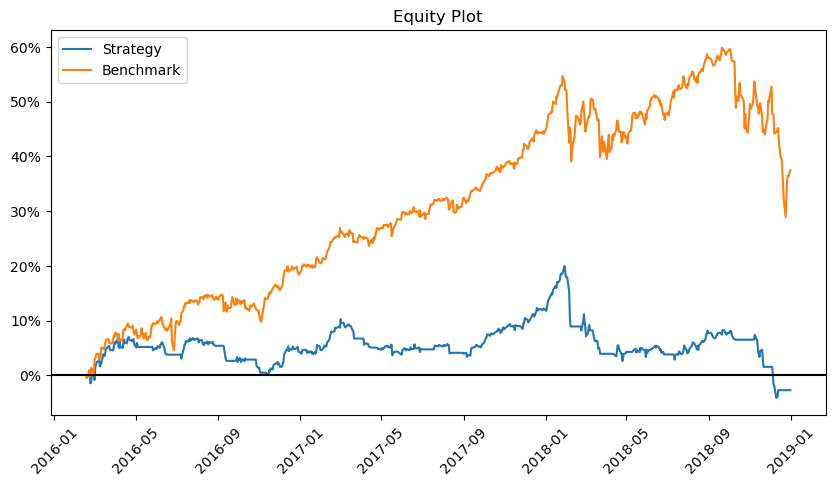

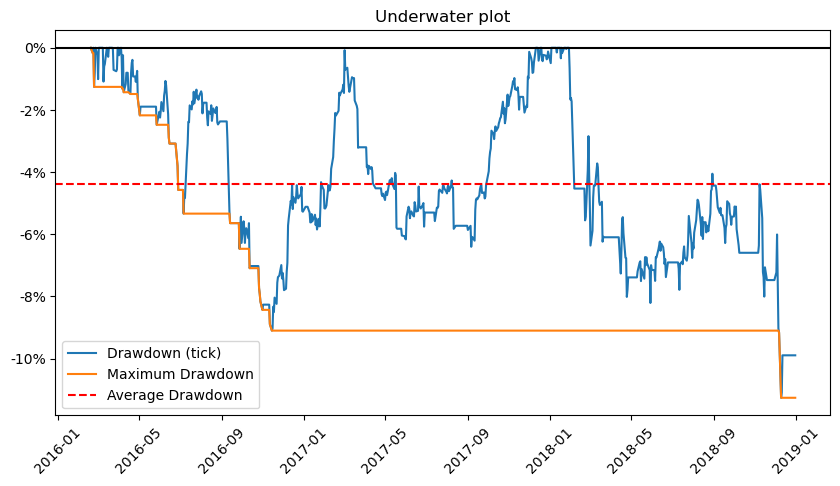

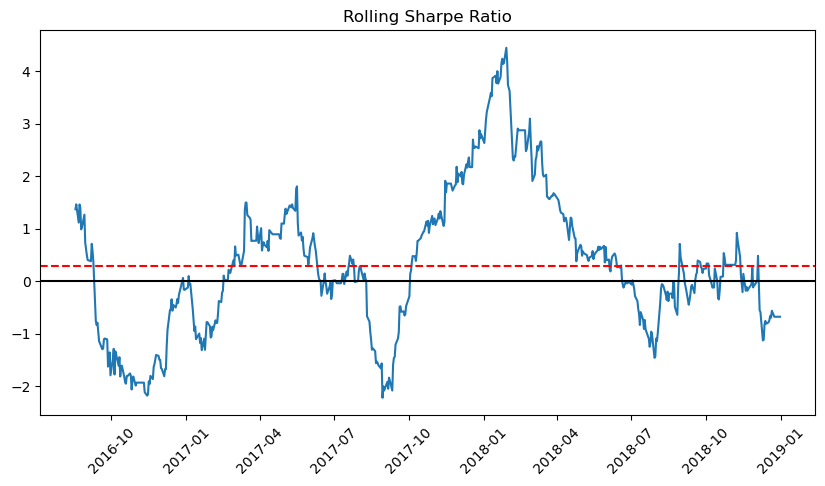

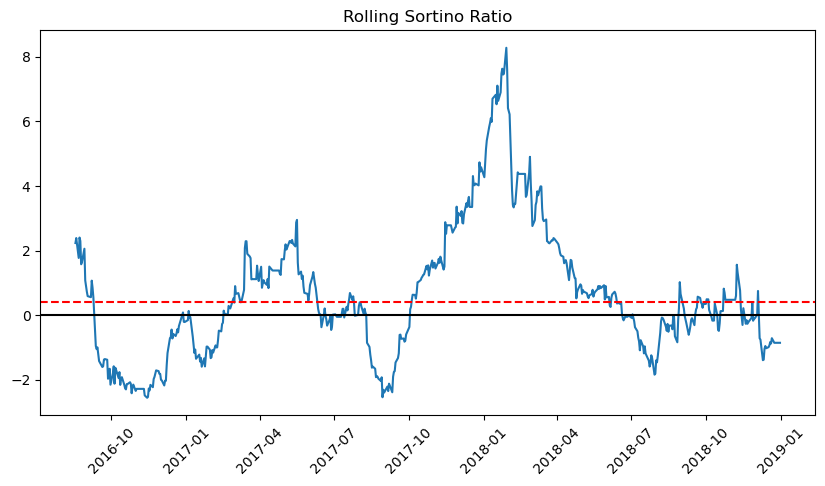

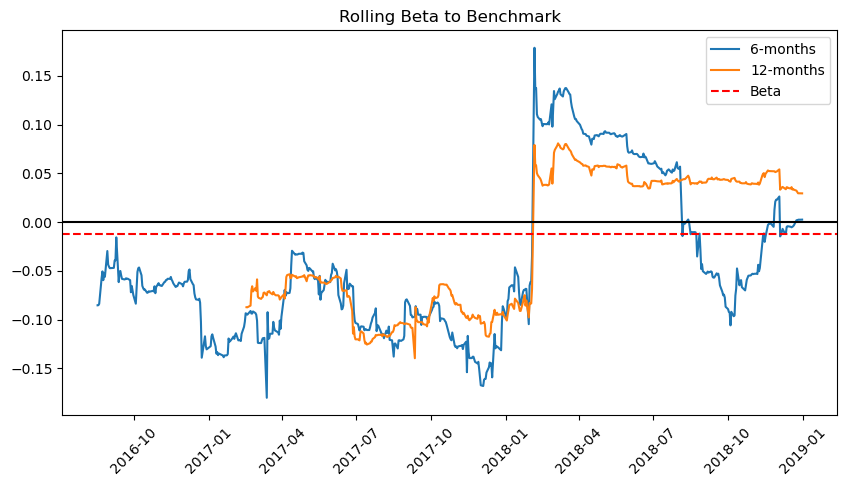

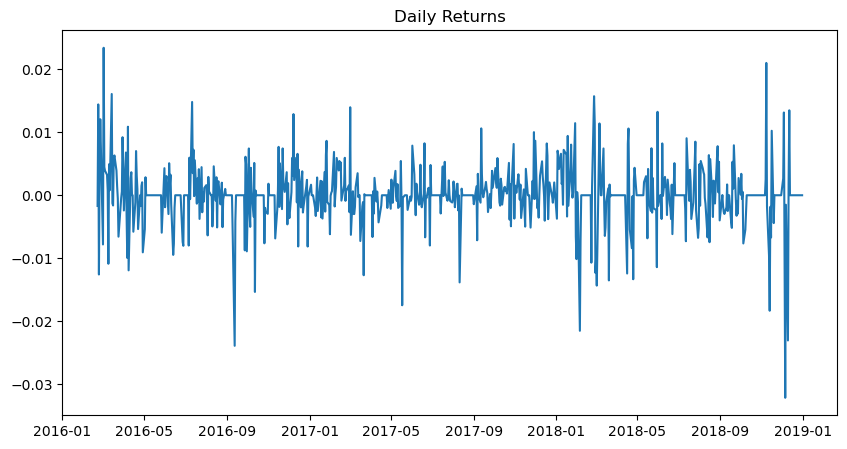

In [2]:
# getting data
data = {}
for asset in MKT:
    ticker = yf.ticker.Ticker(asset.symbol)
    ticker_data = ticker.history(start=BACKTEST_START, end=LIVE_START,
                                 interval='1d')
    data[asset.symbol] = ticker_data

broker = Broker(data=data, initial_capital=CAPITAL, currency=usd)
backtester = Backtester(data)

opt_results = backtester.optimize(
    STRATEGY, broker, PARAMS, target=TARGET, save_logs=False, benchmark=BENCHMARK
)

print(opt_results['best_params'])
backtester.show_report()

Backtest Results
----------------------------------------
Metric           Strategy      Benchmark
----------------------------------------
Total Return:      81.31%        142.37%
Avg gain (day):     0.63%          0.83%
Avg loss (day):    -0.63%         -0.86%
Volatility:        0.1195         0.2033
Sharpe Ratio:      0.9863         0.8177
Sortino Ratio:     1.4342         1.1435
----------------------------------------
Max Drawdown:     -14.23%        -33.72%
Avg Drawdown:      -3.88%         -5.75%
Avg DD Bars:           18             11
Longest DD:           527            488
----------------------------------------
Time in Market:    70.48%           100%
Trades:                45
Best Win:           9.55%
Avg Win:            3.86%
Worst Loss:        -7.11%
Avg Loss:          -2.27%
Win/Loss ratio:      1.50
Win %:             60.00%


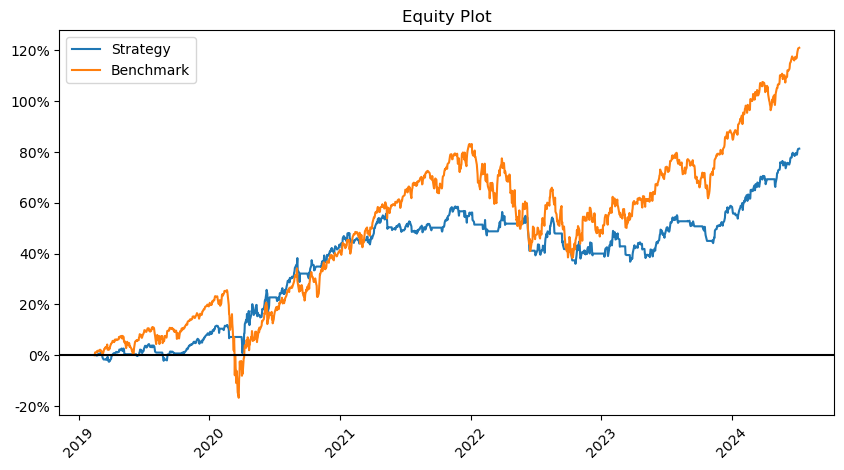

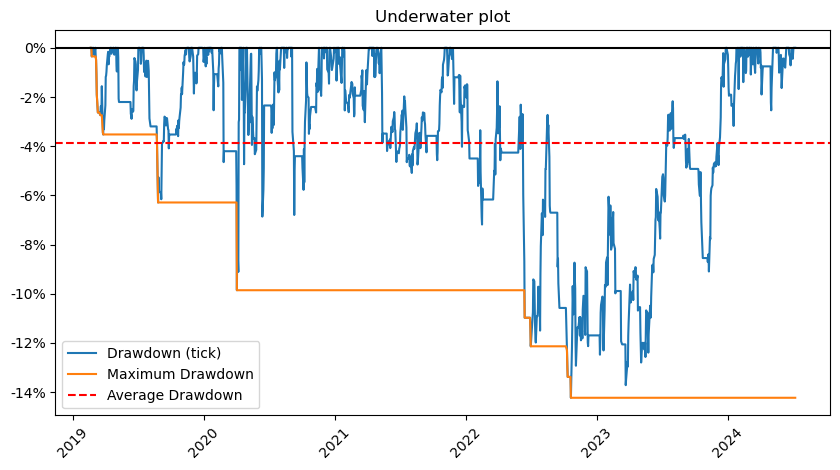

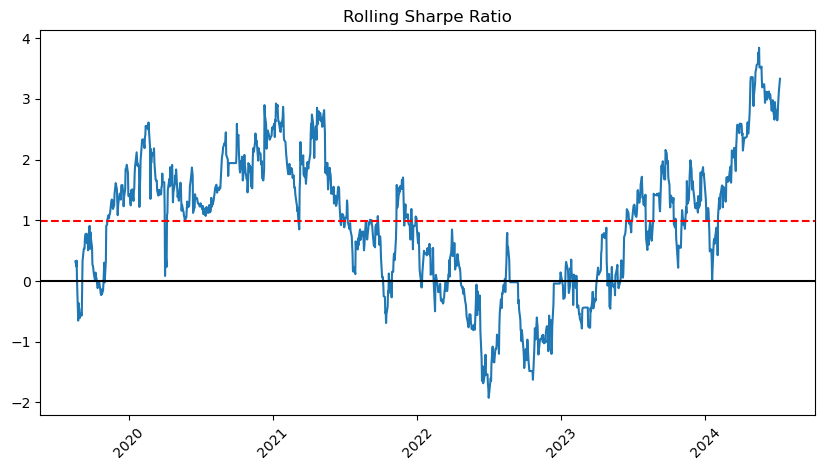

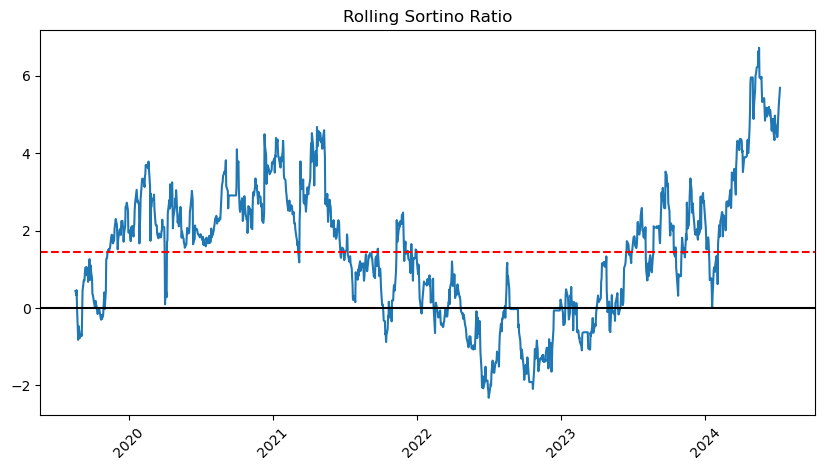

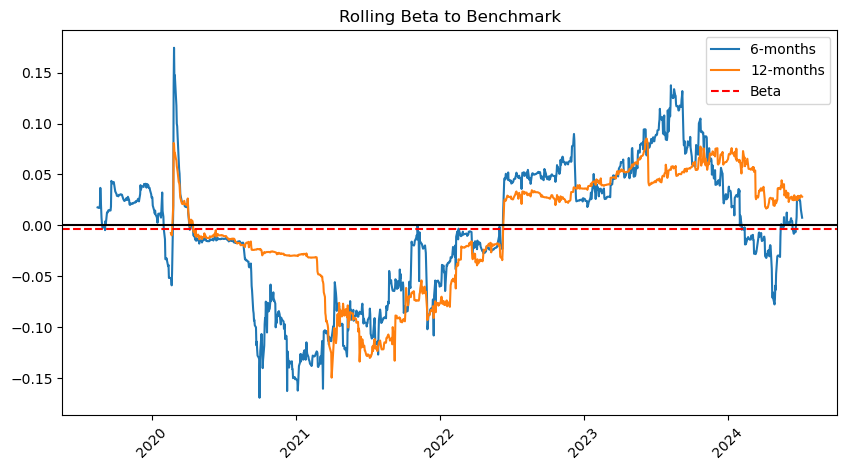

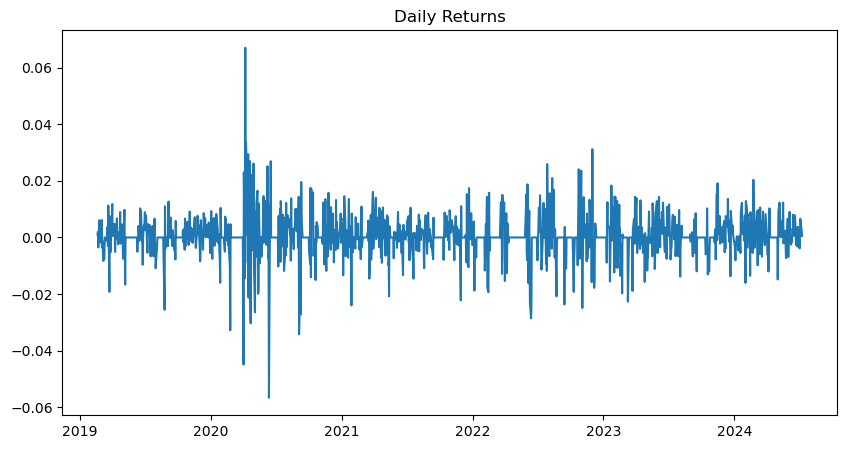

In [3]:
# getting data
data = {}
for asset in MKT:
    ticker = yf.ticker.Ticker(asset.symbol)
    ticker_data = ticker.history(start=LIVE_START, interval='1d')
    data[asset.symbol] = ticker_data

STRATEGY.params = opt_results['best_params']

capital = opt_results['final_equity']

broker = Broker(data=data, initial_capital=capital, currency=usd)
live_backtester = Backtester(data)

live_backtester.run(STRATEGY, broker, save_logs=True)
results = live_backtester.process_results(benchmark=BENCHMARK)
live_backtester.show_report()

In [6]:
returns = results['returns']
benchmark = results['bm_returns']
matrix = np.cov(benchmark, benchmark)
matrix[0,1]/matrix[1,1]

1.0

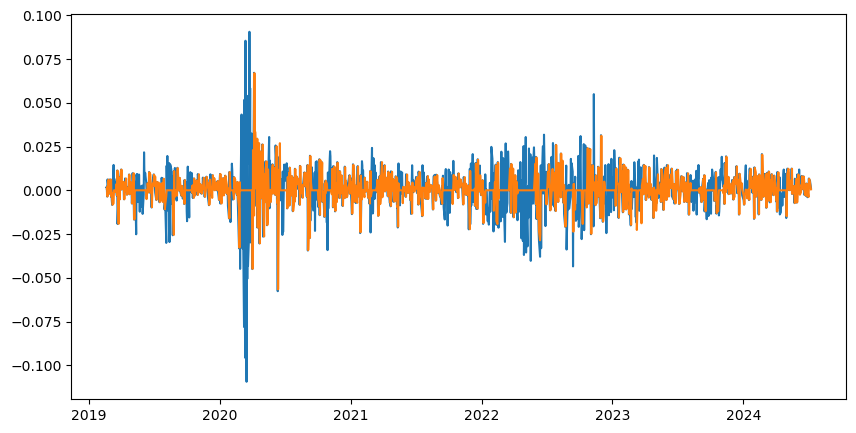

In [9]:
plt.plot(benchmark)
plt.plot(returns)